In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

In [4]:
# Cargamos los datos

PREFIX_PATH = '/home/dparro/zrive-ds_hist/src/module_2/files'


# parte de la orden no comprado
df_carts = pd.read_parquet(f'{PREFIX_PATH}/abandoned_carts.parquet')
# Informacion de producto, precio...
df_inventory = pd.read_parquet(f'{PREFIX_PATH}/inventory.parquet')
# id compra id_cliente ...[cesta comprada]
df_orders = pd.read_parquet(f'{PREFIX_PATH}/orders.parquet')
# productos guardados como habitual por un cliente
df_regulars = pd.read_parquet(f'{PREFIX_PATH}/regulars.parquet')
# infomacion de nuestros usuarios
df_users = pd.read_parquet(f'{PREFIX_PATH}/users.parquet')
pdf_list_invs = [df_carts, df_inventory, df_orders, df_regulars, df_users]

### 1. Distribución general de nuestros clientes

Introducir tema de mucha nulidad

### 2. Estudio de segmentos

#### 2.1. Distribución geográfica

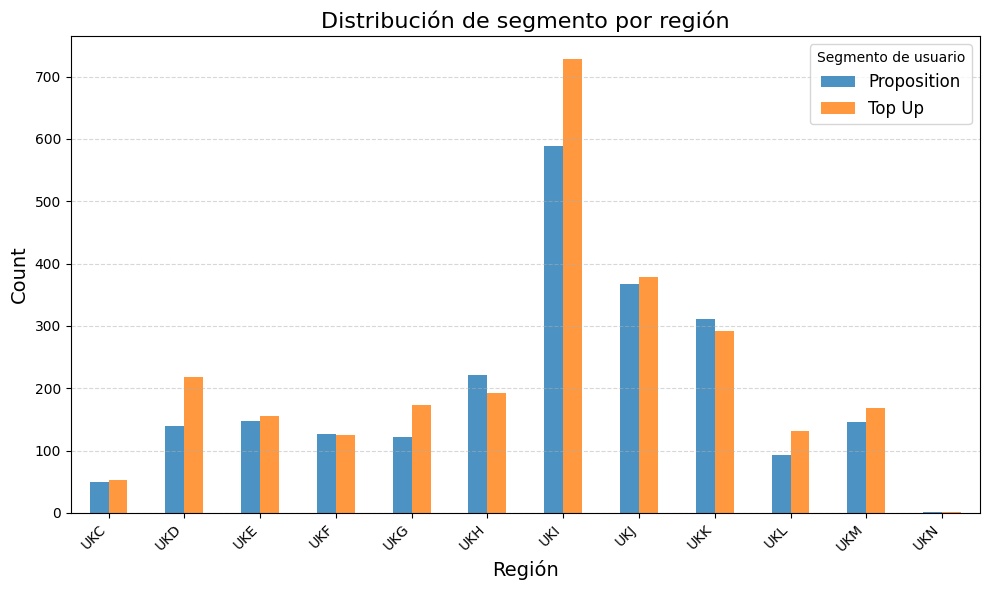

In [19]:
cross_tab = pd.crosstab(df_users['user_nuts1'], df_users['user_segment'])

fig, ax = plt.subplots(figsize=(10, 6))
cross_tab.plot(kind='bar', ax=ax, alpha=0.8)


plt.title('Distribución de segmento por región', fontsize=16)
plt.xlabel('Región', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Segmento de usuario', fontsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 3. Households y segmentos

Para esta parte nos vamos a quedar con aquellos _households_ de los que tenemos información, aunque representen una parte pequeña del total.

In [29]:
# Nos quedamos aquellos que tengan completos todos los datos relativos al hogar
household_columns = df_users.columns[5:]
df_household = df_users.dropna(subset=household_columns)
pct_households = df_household.shape[0]/df_users.shape[0]

Tenemos información del **6.5%** de los hogares, que son **325**. Veamos que información podemos encontrar en ellos.

In [33]:
df_household.describe()

,count_people,count_adults,count_children,count_babies,count_pets
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923
std,1.365753,0.869577,1.026246,0.289086,0.995603
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000


Tenemos un _set_ de clientes que cumple lo siguiente:
* No viven solos en general.
* Hay algún error en los datos, por tener hogares sin adultos.
* Es a partir del percentil 75 donde hay perros y/o niños en casa.
* De forma equivalente nuestros clientes no tienen bebés. También es cierto que es una etapa más corta.

Veamos como se traduce esto en números absolutos. Puede ser interesante separar los hogares que tienen un niño/bebé/mascota de los que no. Es probable que sus patrones de gasto sean distintos.

In [34]:
# Creamos la condición de aquellos que tienen alguien a cargo
cond_has_children = df_household['count_children'] > 0
cond_has_babies = df_household['count_babies'] > 0
cond_has_pets = df_household['count_pets'] > 0
cond_caretaker = cond_has_children | cond_has_babies | cond_has_pets

# Calculamos los totales
total_caretakers = df_household[cond_caretaker].shape[0]
total_non_caretakers = df_household[~cond_caretaker].shape[0]

([<matplotlib.patches.Wedge at 0x7fc1f5df7e90>,
 [Text(-0.372333877000237, -1.0350688305798665, 'Caretakers'),
  Text(0.3723339739103734, 1.0350687957194487, 'Non Caretakers')],
 [Text(-0.20309120563649288, -0.564582998498109, '61.2%'),
  Text(0.20309125849656726, 0.5645829794833356, '38.8%')])

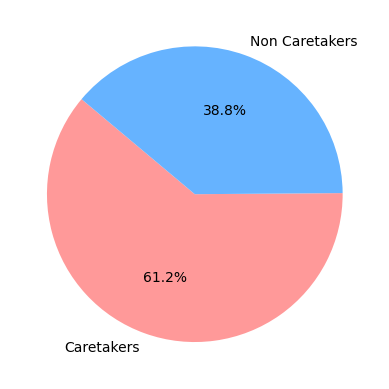

In [48]:
# Distribucion en porcentaje

labels = ['Caretakers', 'Non Caretakers']
sizes = [total_caretakers, total_non_caretakers]
colors = ['#ff9999', '#66b3ff']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

Sobre estos datos. El porcentaje de datos que tenemos informado es bastante pequeño, no extropalaría su comportamiento a la población general, a no ser que no tengamos más de donde tirar y no sea muy costoso probarlo.

Por otro lado se identifican dos segmentos distintos en la población de los que tirar, que pueden tener comportamientos distintos.

### 4. Estudio de regulares

Se plantea ahora evaluar que comportamiento tienen nuestros clientes regulares. Se define un cliente **regular** como aquel cliente que tiene al menos un producto guardado como habitual con la empresa.

Necesitamos además anadir la información del producto, para poder agrupar por categoría, marca, o simplemente ver el producto que es.

In [60]:
df_reg_cli = pd.merge(df_users, df_regulars, on=['user_id'],  how='inner')
df_reg_cli = pd.merge(df_reg_cli, df_inventory, on=['variant_id'], how='left')

Debido a hay algunos productos de los que no tenemos información en el inventario, en ciertos puntos del análisis se omitirán. Cuando se considere que no aportan información relevante.

In [61]:
df_reg_cli = df_reg_cli.drop(columns=['count_people'
                              , 'count_adults'
                              , 'count_children'
                              , 'count_babies'
                              , 'count_pets'], axis=0)


#### 4.1. Por marca

In [169]:
# user_id | prod_id | vendor -> vendor | count(unique_user_id)

df_unique_reg_client_vendor = df_reg_cli[['user_id', 'variant_id', 'vendor']]
df_unique_reg_client_vendor = df_unique_reg_client_vendor.groupby('vendor')['user_id']\
        .nunique()\
        .reset_index()\
        .sort_values(by=['user_id'], ascending=False)
df_unique_reg_client_vendor = df_unique_reg_client_vendor.rename(columns={'user_id': 'user_id_count'})



<BarContainer object of 367 artists>

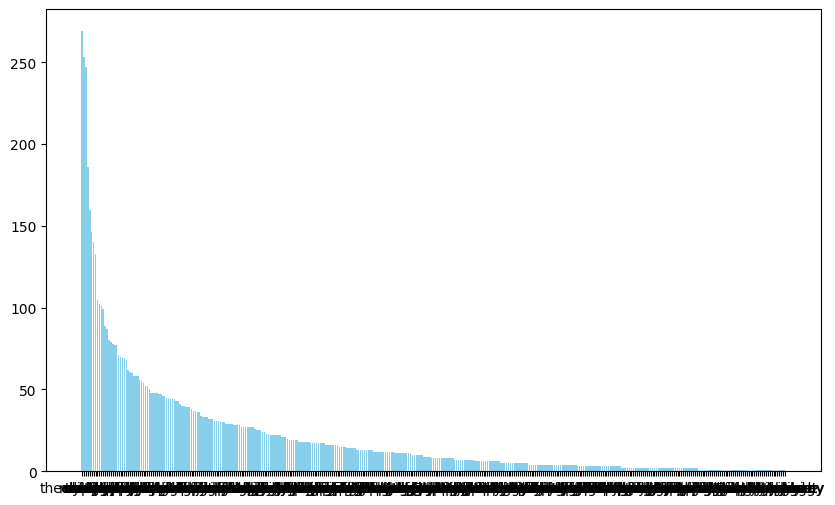

In [170]:
# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_unique_reg_client_vendor['vendor'], df_unique_reg_client_vendor['user_id_count'], color='skyblue')


A fin de hacerlo mas claro nos quedamos solo con los primeros para ver quien puede ser interesante

<BarContainer object of 14 artists>

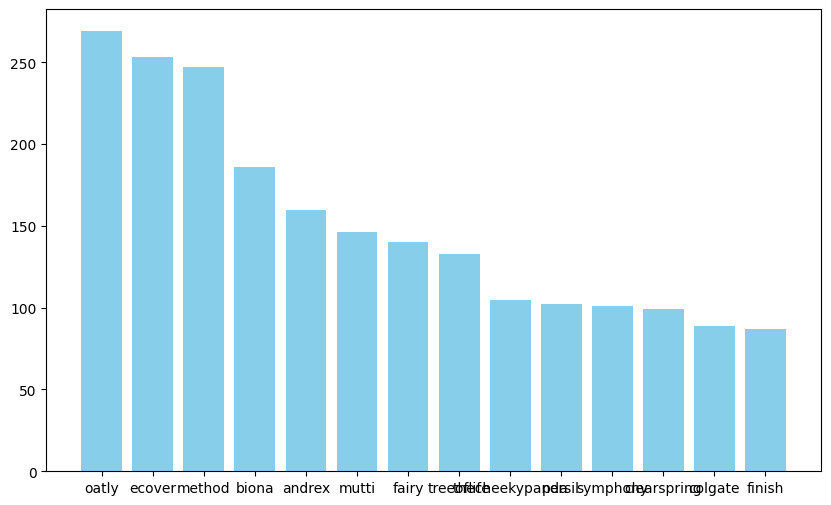

In [171]:
df_clear_plot = df_unique_reg_client_vendor[df_unique_reg_client_vendor['user_id_count']>80]
# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_clear_plot['vendor'], df_clear_plot['user_id_count'], color='skyblue')


Se puede observar que las marcas que más predominan entre los clientes regulares son las marcas "eco" y las marcas de productos de limpieza.

#### 4.2. Por tipo

In [173]:
# user_id | prod_id | vendor -> vendor | count(unique_user_id)

df_unique_reg_client_ptype = df_reg_cli[['user_id', 'variant_id', 'product_type']]
df_unique_reg_client_ptype = df_unique_reg_client_ptype.groupby('product_type')['user_id']\
        .nunique()\
        .reset_index()\
        .sort_values(by=['user_id'], ascending=False)
df_unique_reg_client_ptype = df_unique_reg_client_ptype.rename(columns={'user_id': 'user_id_count'})



<BarContainer object of 58 artists>

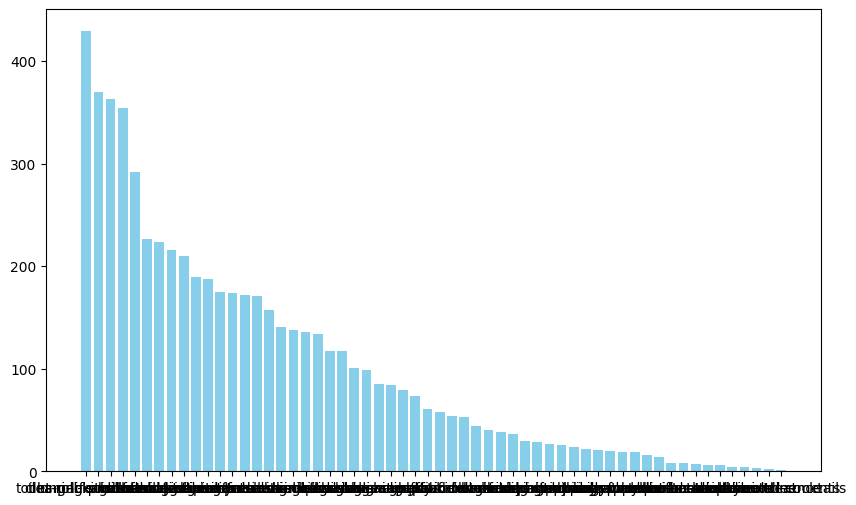

In [174]:
# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_unique_reg_client_ptype['product_type'], df_unique_reg_client_ptype['user_id_count'], color='skyblue')


De forma análoga al anterior se procede a simplificar el gráfico

<BarContainer object of 5 artists>

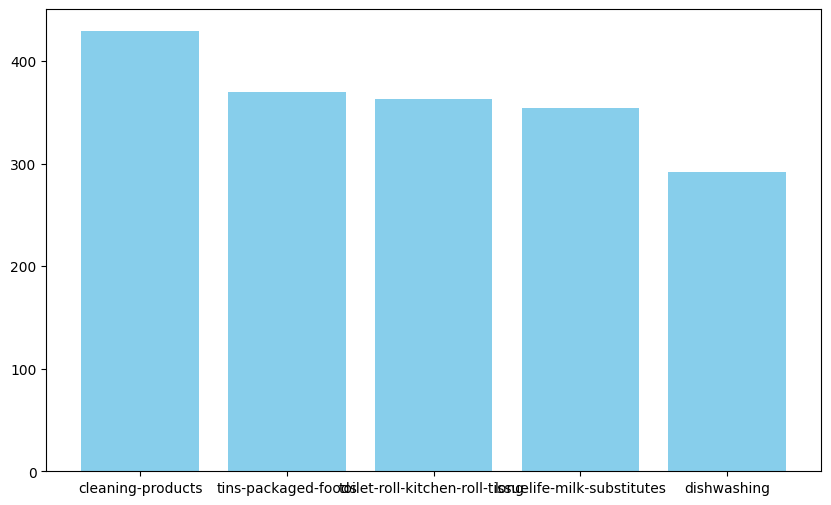

In [175]:
df_clear_plot_ptype = df_unique_reg_client_ptype[df_unique_reg_client_ptype['user_id_count']>250]
# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_clear_plot_ptype['product_type'], df_clear_plot_ptype['user_id_count'], color='skyblue')


Que nos empieza a dar una idea del tipo de productos que fidelizan en el supermercado

##### 4.5. Conclusiones

Las marcas y tipo de producto que compran el tipo de clientes regulares de este supermercado, se concentran en productos de limpieza, productos de cocina y lácteos. Dentro de las marcas predominan tanto las de este tipo de productos, como las que tienen un enfoque eco.

De cara a posibles acciones comerciales está bien conocer este tipo de preferencias.

### 5. Estudio de recopilación de datos

Una pregunta se puede plantear, en vista del gran número de nuloes es la siguiente. ¿Ha mejorado la capacidad de recopilación de datos en el tiempo? Para esto planteamos lo siguiente.

Un gráfico de porcentaje de registros con datos nulos sobre las columnas del producto, en la orden de compra, por semana.

In [103]:
# Separamos de forma que queda una orden en cada columna

df_orders_exploited = df_orders\
        .explode('ordered_items')\
        .rename(columns={'ordered_items': 'variant_id'})

In [108]:
# Vemos aquellos datos que presentan nulos frente a los que no

df_orders_info_prod = pd.merge(df_orders_exploited, df_inventory
                               , on=['variant_id']
                               , how='left')

price_columns = df_inventory.columns

df_is_na = df_orders_info_prod[df_orders_info_prod[[*price_columns]].isna().any(axis=1)]
df_is_not_na = df_orders_info_prod[~df_orders_info_prod[[*price_columns]].isna().any(axis=1)]
                          

In [127]:
nan_counts = df_is_na.groupby('order_date')\
            .size()\
            .sort_values(ascending=False)
non_nan_counts = df_is_not_na.groupby('order_date')\
            .size()\
            .sort_values(ascending=False)

# Para verlo proporcional
total_counts = nan_counts.add(non_nan_counts, fill_value=0)

ratio_nan = nan_counts.div(total_counts, fill_value=0)

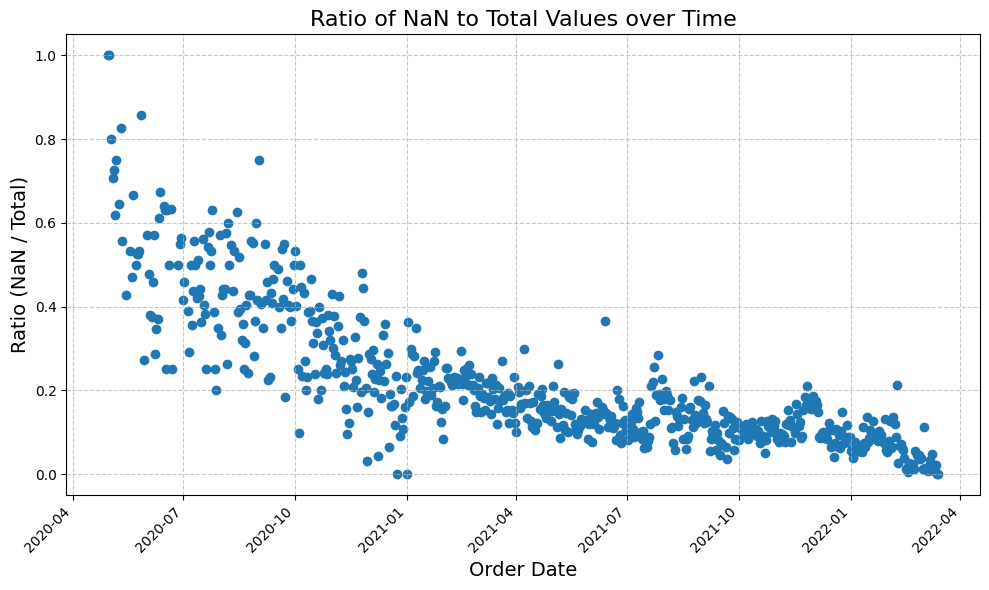

In [137]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(ratio_nan.index, ratio_nan.values, marker='o', linestyle='-')

# Textos
plt.title('Ratio of NaN to Total Values over Time', fontsize=16)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Ratio (NaN / Total)', fontsize=14)

# Estilo
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Esto es muy interesante, ya podemos sacar la conclusión de que **se está mejorando la capacidad de recogida de información a medida que avanza el tiempo.** Por tanto podremos modelar mejor en el futuro. Se puede dar más importancia a esta nueva información (que además se parecerá más a la distribución presente, probablemente).

### 6. Estudio de _orders_

#### 6.1. Generalidades

Nos hacemos primero una serie de preguntas genéricas para entender como se comportan nuestras órdenes.

In [141]:
# Ventana temporal en la que se realizan las órdenes

df_orders['order_date'].min(), df_orders['order_date'].max()

# Se tiene entonces casi dos años de información

(Timestamp('2020-04-30 00:00:00'), Timestamp('2022-03-14 00:00:00'))

In [147]:
# Total de usuarios únicos en el tiempo

df_orders['user_id'].unique().shape[0]

4983

In [157]:
# Usuarios con más de una orden

orders_per_user = df_orders.groupby('user_id').size()
users_with_multiple_orders = orders_per_user[orders_per_user > 1]
users_with_multiple_orders.shape[0]


1411

Esto nos da un **28%**. De forma natural se plantea la pregunta de como es la distribución de usuarios por número de veces que han comprado en el supermercado.

In [161]:
orders_per_user = df_orders.groupby('user_id').size()

users_per_order_count = orders_per_user.groupby(orders_per_user).size()

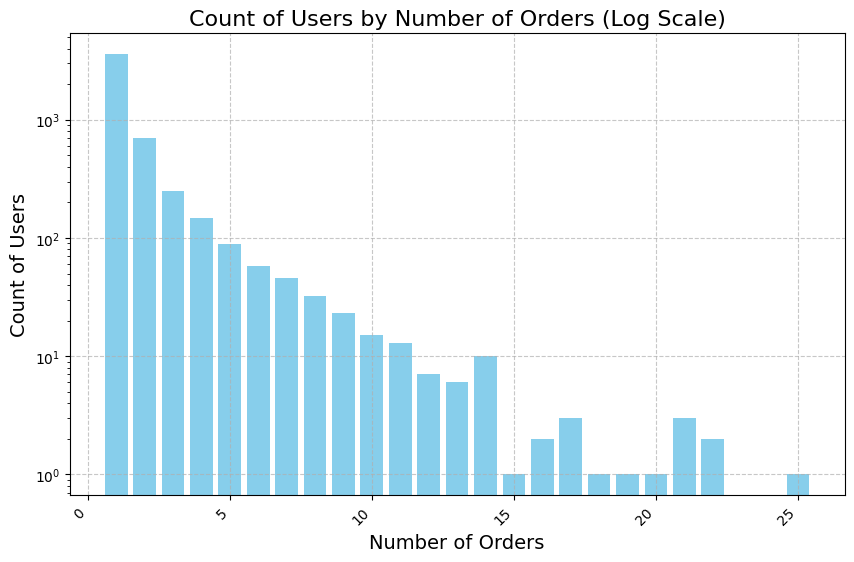

In [168]:
# plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(users_per_order_count.index, users_per_order_count.values, color='skyblue')

# texto
plt.title('Count of Users by Number of Orders (Log Scale)', fontsize=16)
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Count of Users', fontsize=14)

# formato
plt.yscale('log')
plt.xticks(rotation=45, ha='right')  
plt.grid(True, linestyle='--', alpha=0.7)

Que es una distribución que tiene sentido pensándolo en términos de cliente ocasional y fuga de clientes.

#### 6.2. Distribución por categoría.

<BarContainer object of 58 artists>

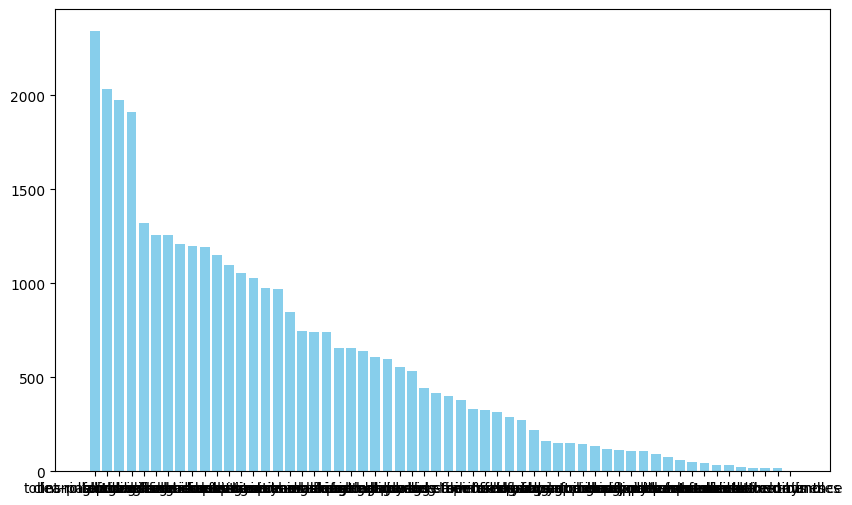

In [186]:
# Reutilizamos el codig que teniamos antes pero con la base total de clientes
df_orders_ptype = df_orders_info_prod[['user_id', 'variant_id', 'product_type']]
df_orders_ptype = df_orders_ptype.groupby('product_type')['user_id']\
        .nunique()\
        .reset_index()\
        .sort_values(by=['user_id'], ascending=False)
df_orders_ptype = df_orders_ptype.rename(columns={'user_id': 'user_id_count'})

# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_orders_ptype['product_type'], df_orders_ptype['user_id_count'], color='skyblue')

<BarContainer object of 4 artists>

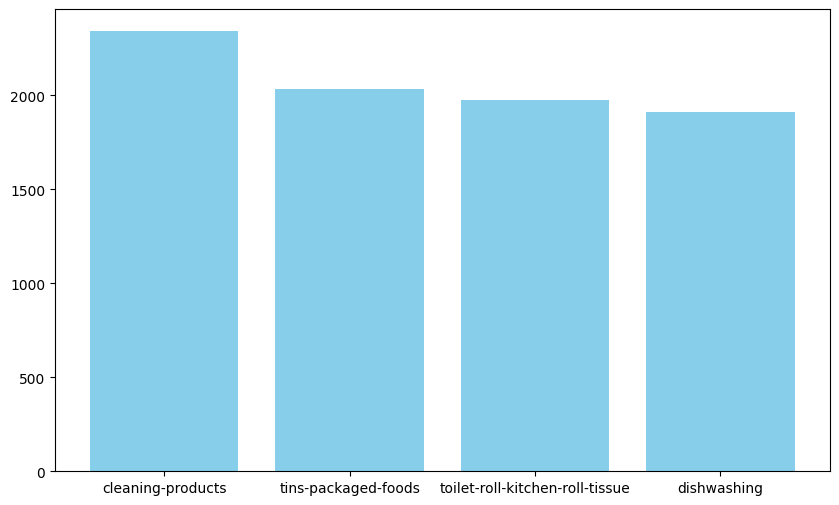

In [191]:
# Presentamos ahora, por claridad, los que más. Que coinciden con los de los regulares.
df_orders_ptype_great = df_orders_ptype[df_orders_ptype['user_id_count']>1500]
plt.figure(figsize=(10, 6))
plt.bar(df_orders_ptype_great['product_type'], df_orders_ptype_great['user_id_count'], color='skyblue')

#### 6.3. Distribución por marca

<BarContainer object of 402 artists>

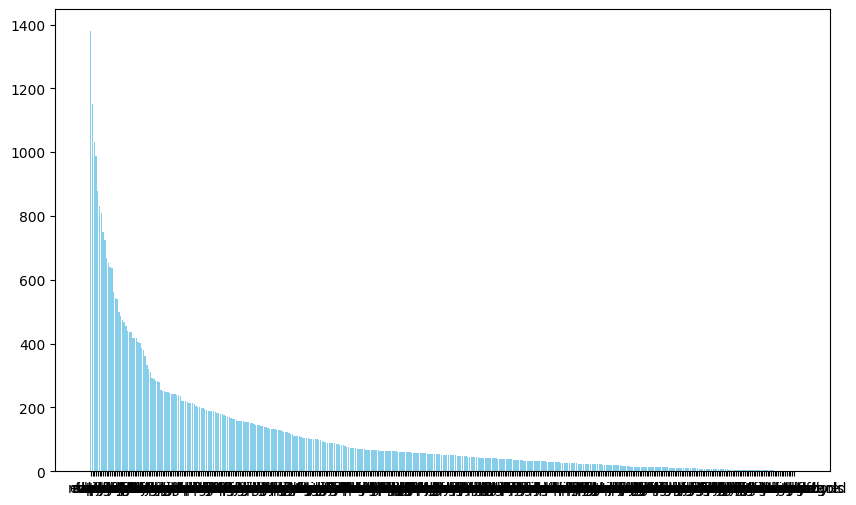

In [202]:
df_orders_vtype = df_orders_info_prod[['user_id', 'variant_id', 'vendor']]
df_orders_vtype = df_orders_vtype.groupby('vendor')['user_id']\
        .nunique()\
        .reset_index()\
        .sort_values(by=['user_id'], ascending=False)
df_orders_vtype = df_orders_vtype.rename(columns={'user_id': 'user_id_count'})
# Ploteamos
plt.figure(figsize=(10, 6))
plt.bar(df_orders_vtype['vendor'], df_orders_vtype['user_id_count'], color='skyblue')

<BarContainer object of 7 artists>

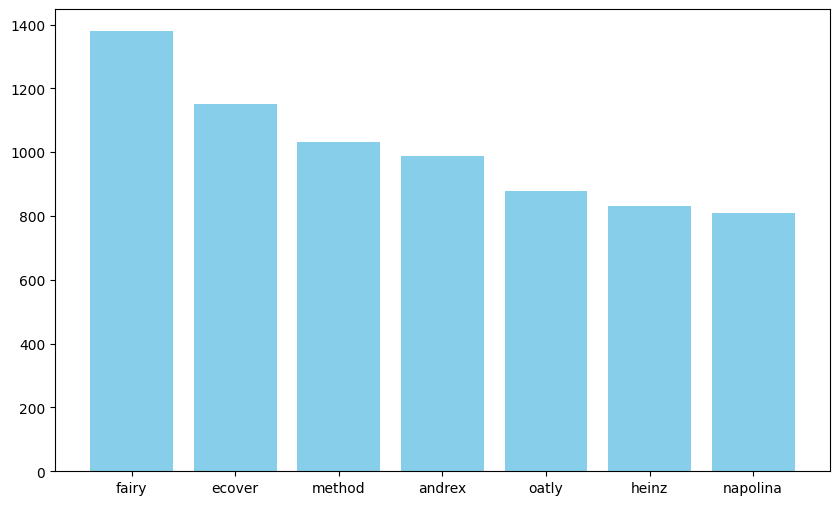

In [205]:
# Presentamos ahora, por claridad, los que más. Que coinciden con los de los regulares.
df_orders_vtype_great = df_orders_vtype[df_orders_vtype['user_id_count']>800]
plt.figure(figsize=(10, 6))
plt.bar(df_orders_vtype_great['vendor'], df_orders_vtype_great['user_id_count'], color='skyblue')

### 7. Estudio del valor de nuestros clientes

Es interesante estudiar como se comporta, tanto el tamaño de la orden como su valor en el tiempo, de cara a entender el posible comportamiento estacional de los clientes. O bien simplemente la distribución.

#### 7.1. Distribución en el tiempo del _order_size_

In [212]:
df_ord_size = df_orders[['id', 'order_date', 'ordered_items']]
df_ord_size['ordered_items_length'] = df_ord_size['ordered_items'].apply(lambda x: len(x))


/tmp/ipykernel_84087/1042493153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ord_size['ordered_items_length'] = df_ord_size['ordered_items'].apply(lambda x: len(x))


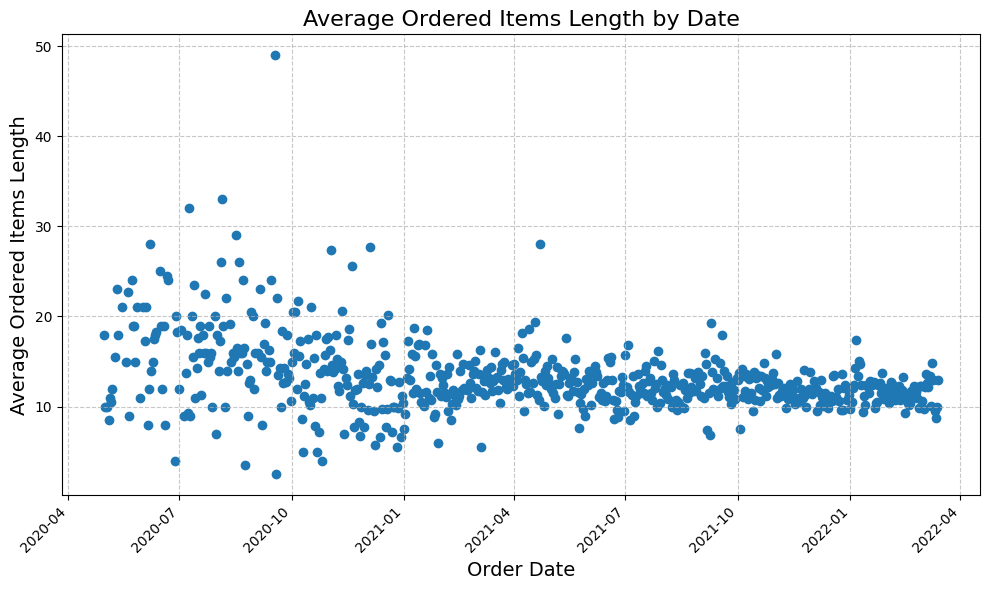

In [226]:
avg_ordered_items_length_by_date = df_ord_size\
                                        .groupby('order_date')['ordered_items_length']\
                                        .mean()
# plot
plt.figure(figsize=(10, 6))
plt.scatter(avg_ordered_items_length_by_date.index
                , avg_ordered_items_length_by_date.values
                , marker='o'
                , linestyle='-')

# texto
plt.title('Average Ordered Items Length by Date', fontsize=16)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Average Ordered Items Length', fontsize=14)

# formato
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se observa una menor dispersión en el tamaño de la orden a lo largo del tiempo. Siendo Estable a partir de abril de 2021.

#### 7.2. Distribución en el tiempo del precio del carrito

Calculamos el precio del carrito. Ahora bien este precio esta sesgado por si tenemos información o no del precio en el inventario. Para lidiar con esto tendremos en cuenta este porcentaje, para aportar veracidad o no al dato.

In [245]:
total_price_per_order = df_orders_info_prod.groupby('id')['price'].sum()
pct_nulls = df_orders_info_prod.groupby('id')['price'].apply(lambda x: x.isnull().mean())

df_price_base = df_orders[['id', 'order_date']]
df_price_base = pd.merge(df_price_base, total_price_per_order, on=['id'], how='left')
df_price_base = pd.merge(df_price_base, pct_nulls, on=['id'], how='left')
df_price_base = df_price_base.rename(columns={'price_x': 'order_price', 'price_y': 'pct_nulls'})



In [247]:
avg_price_pct_nulls_by_date = df_price_base.groupby('order_date')\
                .agg({'order_price': 'mean', 'pct_nulls': 'mean'})


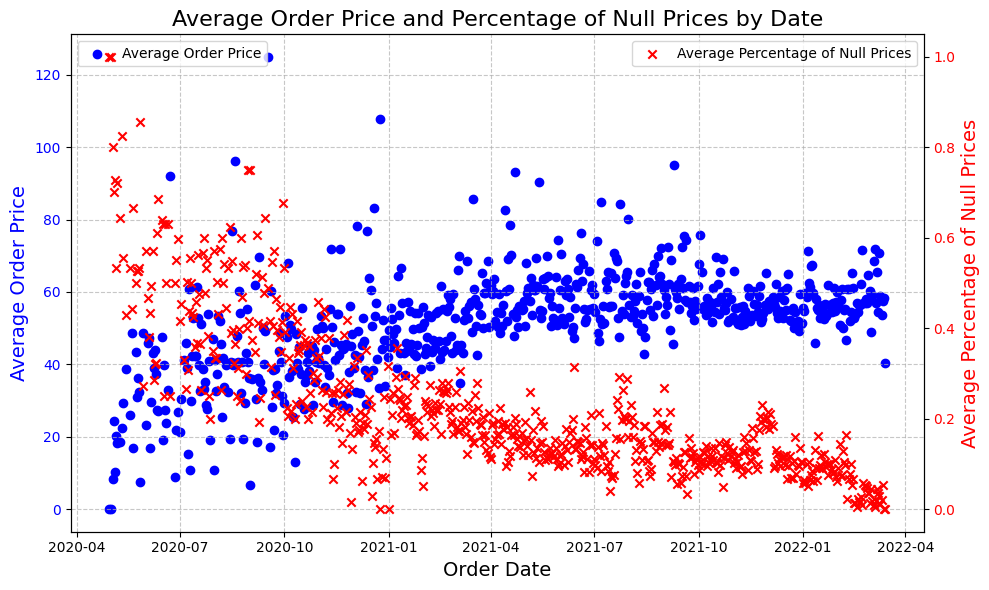

In [252]:
# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot: precio de la orden en el eje y de la izquierda
ax1.scatter(avg_price_pct_nulls_by_date.index, avg_price_pct_nulls_by_date['order_price'], marker='o', linestyle='-', color='blue', label='Average Order Price')
ax1.set_xlabel('Order Date', fontsize=14)
ax1.set_ylabel('Average Order Price', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# porcentaje de nulos en el eje de la derecha
ax2 = ax1.twinx()
ax2.scatter(avg_price_pct_nulls_by_date.index, avg_price_pct_nulls_by_date['pct_nulls'], marker='x', linestyle='-', color='red', label='Average Percentage of Null Prices')
ax2.set_ylabel('Average Percentage of Null Prices', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

#titulo
plt.title('Average Order Price and Percentage of Null Prices by Date', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Este es super interesante. Porque en una primera impresión podríamos pensar que el precio medio del carrito ha crecido en el tiempo, pero este revela que lo más probable es que no. Lo más probable es simplemente que al completar la información de los precios obtenemos el valor real.

La estrategía de recopilación de datos ha mejorado bastante.

#### 7.3. Retención (añadido por la clase)

Lo he visto en la clase, me ha parecido interesante, pues no lo conocía. Idem a la clase.

# EDA 2

In [254]:
df_model = pd.read_csv('/home/dparro/zrive-ds_hist/src/module_2/files/feature_frame.csv')

In [258]:
df_model.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [257]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [259]:
# Separamos las columnas en funcion de su tipo

target  = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
feature_cols = [_ for _ in df_model.columns if _ not in [target] + info_cols]
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular'] 
categ_cols = ['product_type', 'vendor']
numeric_cols = [col for col in feature_cols if col not in binary_cols + categ_cols]

### Estudiamos el balanceo del target y del target respecto a las binarias.

In [264]:
# Absolutos
target_counts = df_model[target].value_counts()


binary_counts = {}
for col in binary_cols:
    binary_counts[col] = df_model.groupby(col)[target].value_counts().unstack(fill_value=0)

print("Counts of 0s and 1s in the target column:")
print(target_counts)
print("\nCounts of 0s and 1s in the target column with respect to each binary column:")
for col, count in binary_counts.items():
    print(f"\nCounts for binary column '{col}':")
    print(count)

Counts of 0s and 1s in the target column:
outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

Counts of 0s and 1s in the target column with respect to each binary column:

Counts for binary column 'ordered_before':
outcome             0.0    1.0
ordered_before                
0.0             2796471  23187
1.0               50846  10045

Counts for binary column 'abandoned_before':
outcome               0.0    1.0
abandoned_before                
0.0               2846822  31972
1.0                   495   1260

Counts for binary column 'active_snoozed':
outcome             0.0    1.0
active_snoozed                
0.0             2841469  32483
1.0                5848    749

Counts for binary column 'set_as_regular':
outcome             0.0    1.0
set_as_regular                
0.0             2839472  30621
1.0                7845   2611


In [263]:
# Porcentajes
total_count = df_model[target].count()

target_counts = df_model[target].value_counts()
target_percentages = target_counts / total_count * 100

binary_percentages = {}
for col in binary_cols:
    binary_group_counts = df_model.groupby(col)[target].value_counts().unstack(fill_value=0)
    binary_group_percentages = binary_group_counts.div(binary_group_counts.sum(axis=1), axis=0) * 100
    binary_percentages[col] = binary_group_percentages

print("Percentages of 0s and 1s in the target column:")
print(target_percentages)
print("\nPercentages of 0s and 1s in the target column with respect to each binary column:")
for col, percentages in binary_percentages.items():
    print(f"\nPercentages for binary column '{col}':")
    print(percentages)


Percentages of 0s and 1s in the target column:
outcome
0.0    98.846331
1.0     1.153669
Name: count, dtype: float64

Percentages of 0s and 1s in the target column with respect to each binary column:

Percentages for binary column 'ordered_before':
outcome               0.0        1.0
ordered_before                      
0.0             99.177666   0.822334
1.0             83.503309  16.496691

Percentages for binary column 'abandoned_before':
outcome                 0.0        1.0
abandoned_before                      
0.0               98.889396   1.110604
1.0               28.205128  71.794872

Percentages for binary column 'active_snoozed':
outcome               0.0        1.0
active_snoozed                      
0.0             98.869745   1.130255
1.0             88.646354  11.353646

Percentages for binary column 'set_as_regular':
outcome               0.0        1.0
set_as_regular                      
0.0             98.933101   1.066899
1.0             75.028692  24.971308


In [265]:
numeric_cols

['user_order_seq',
 'normalised_price',
 'discount_pct',
 'global_popularity',
 'count_adults',
 'count_children',
 'count_babies',
 'count_pets',
 'people_ex_baby',
 'days_since_purchase_variant_id',
 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id',
 'days_since_purchase_product_type',
 'avg_days_to_buy_product_type',
 'std_days_to_buy_product_type']

### Correlación

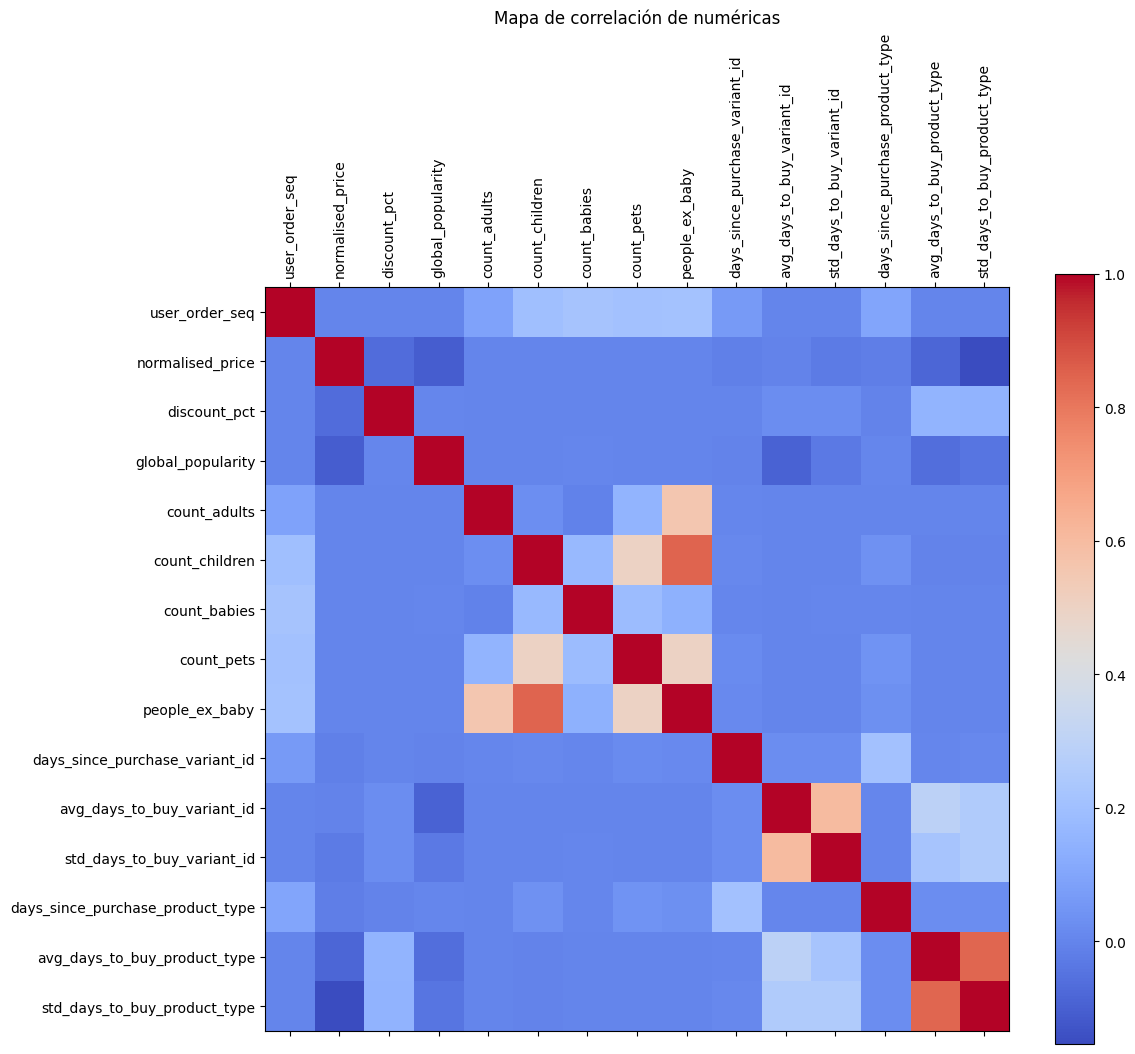

In [272]:
correlation_matrix = df_model[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
cbar = fig.colorbar(cax)
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)

plt.title('Mapa de correlación de numéricas')
plt.show()


Se observa que no existe ninguna variable especialmente correlacionada.

### Distribución de categóricas.

In [274]:
cardinality = {col: df_model[col].nunique() for col in categ_cols}
for col, value in cardinality.items():
    print(f"Cardinality of '{col}': {value}")


Cardinality of 'product_type': 62
Cardinality of 'vendor': 264


Son columnas con una cardinalidad altísima, especialmente _vendor_. En ninguna de las dos es una opción usar _one-hot_. Habrá que probar con métodos que compriman información (target_encoding?, hash de menos dimensión?).

### Distribución de la variable objetivo.

In [ ]:
# Añado el gráfico de la clase, que es muy bueno.

cols = 3
rows = int(np.ceil(len(numeric_cols))/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))

for i, cols in enumerate(categ_cols):
    sns.kdeplot(df_model.loc[lambda x: x.outcome == 0, col], label='0', ax=ax[i])
    sns.kdeplot(df_model.loc[lambda x: x.outcome == 1, col], label='1', ax=ax[i])
    ax[i].set_tittle(col)
ax[0].legend()
plt.tight_layout()